In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random


In [ ]:

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
epochs = 50
latent_dim = 20

In [ ]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# VAE Model Definition
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output between 0 and 1
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
# Loss function
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross entropy)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD, BCE, KLD

# Initialize model, optimizer
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Function to add noise to images
def add_noise(images, noise_factor=0.5):
    """
    Add Gaussian noise to images
    """
    noisy_images = images + noise_factor * torch.randn_like(images)
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

In [ ]:
# Training function
def train(model, dataloader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_bce = 0
    train_kld = 0
    
    for batch_idx, (data, _) in enumerate(dataloader):
        # Add noise to the data
        noisy_data = add_noise(data, noise_factor=0.5)
        noisy_data = noisy_data.to(device)
        data = data.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(noisy_data)
        loss, bce, kld = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        train_bce += bce.item()
        train_kld += kld.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} '
                  f'({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    avg_loss = train_loss / len(dataloader.dataset)
    avg_bce = train_bce / len(dataloader.dataset)
    avg_kld = train_kld / len(dataloader.dataset)
    
    return avg_loss, avg_bce, avg_kld

Using device: cpu


100%|██████████| 9.91M/9.91M [00:06<00:00, 1.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 258kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.09MB/s]


Starting training...
Train Epoch: 1 [0/60000 (0%)]	Loss: 544.844299
Train Epoch: 1 [12800/60000 (21%)]	Loss: 207.985443
Train Epoch: 1 [25600/60000 (43%)]	Loss: 195.455826
Train Epoch: 1 [38400/60000 (64%)]	Loss: 186.748825
Train Epoch: 1 [51200/60000 (85%)]	Loss: 180.111359
====> Test set loss: 173.0522, BCE: 167.8566, KLD: 5.1956
Epoch 1: Train Loss: 197.1439, Test Loss: 173.0522
Train Epoch: 2 [0/60000 (0%)]	Loss: 175.137375
Train Epoch: 2 [12800/60000 (21%)]	Loss: 169.960587
Train Epoch: 2 [25600/60000 (43%)]	Loss: 163.322784
Train Epoch: 2 [38400/60000 (64%)]	Loss: 151.250397
Train Epoch: 2 [51200/60000 (85%)]	Loss: 144.999481
====> Test set loss: 149.5392, BCE: 140.6988, KLD: 8.8404
Epoch 2: Train Loss: 160.1629, Test Loss: 149.5392
Train Epoch: 3 [0/60000 (0%)]	Loss: 155.040237
Train Epoch: 3 [12800/60000 (21%)]	Loss: 154.309509
Train Epoch: 3 [25600/60000 (43%)]	Loss: 143.166199
Train Epoch: 3 [38400/60000 (64%)]	Loss: 143.772568
Train Epoch: 3 [51200/60000 (85%)]	Loss: 144.097

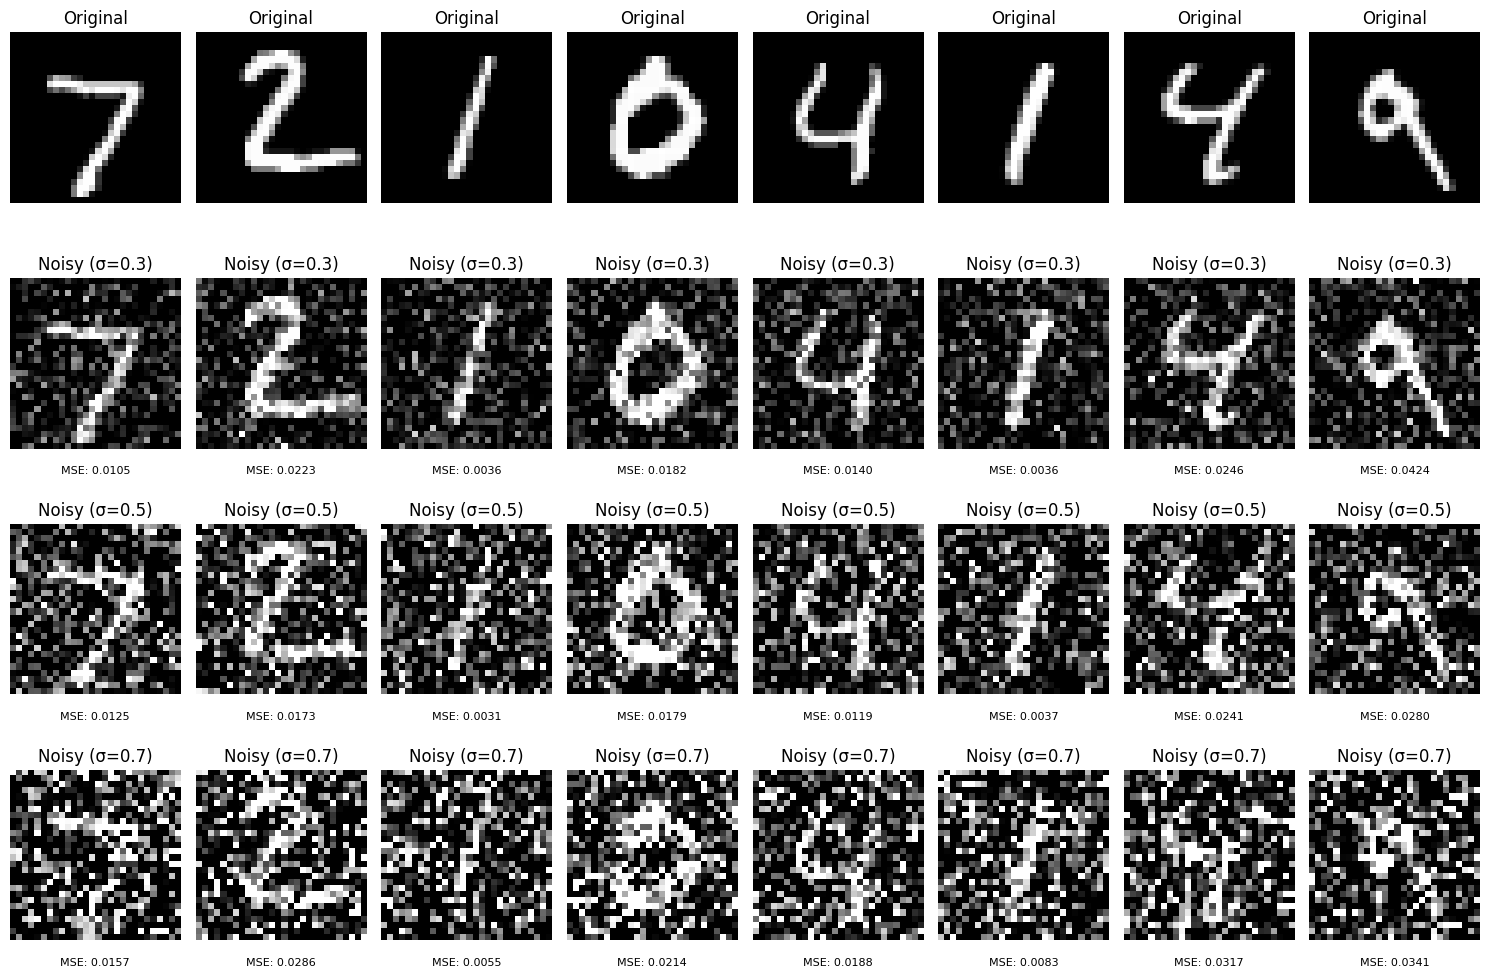


Calculating quantitative metrics...
Quantitative Results (noise σ=0.5):
Average MSE: 0.020973
Average PSNR: 17.30 dB


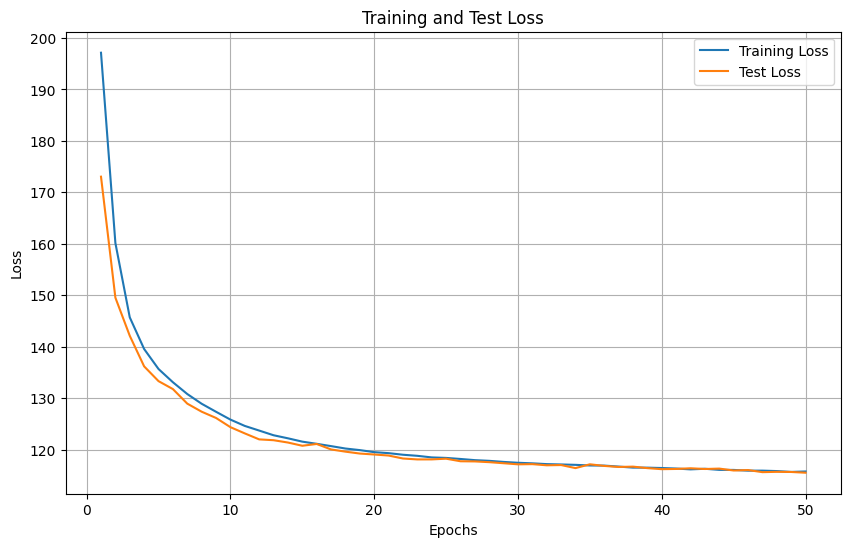


Showing detailed examples with error analysis...


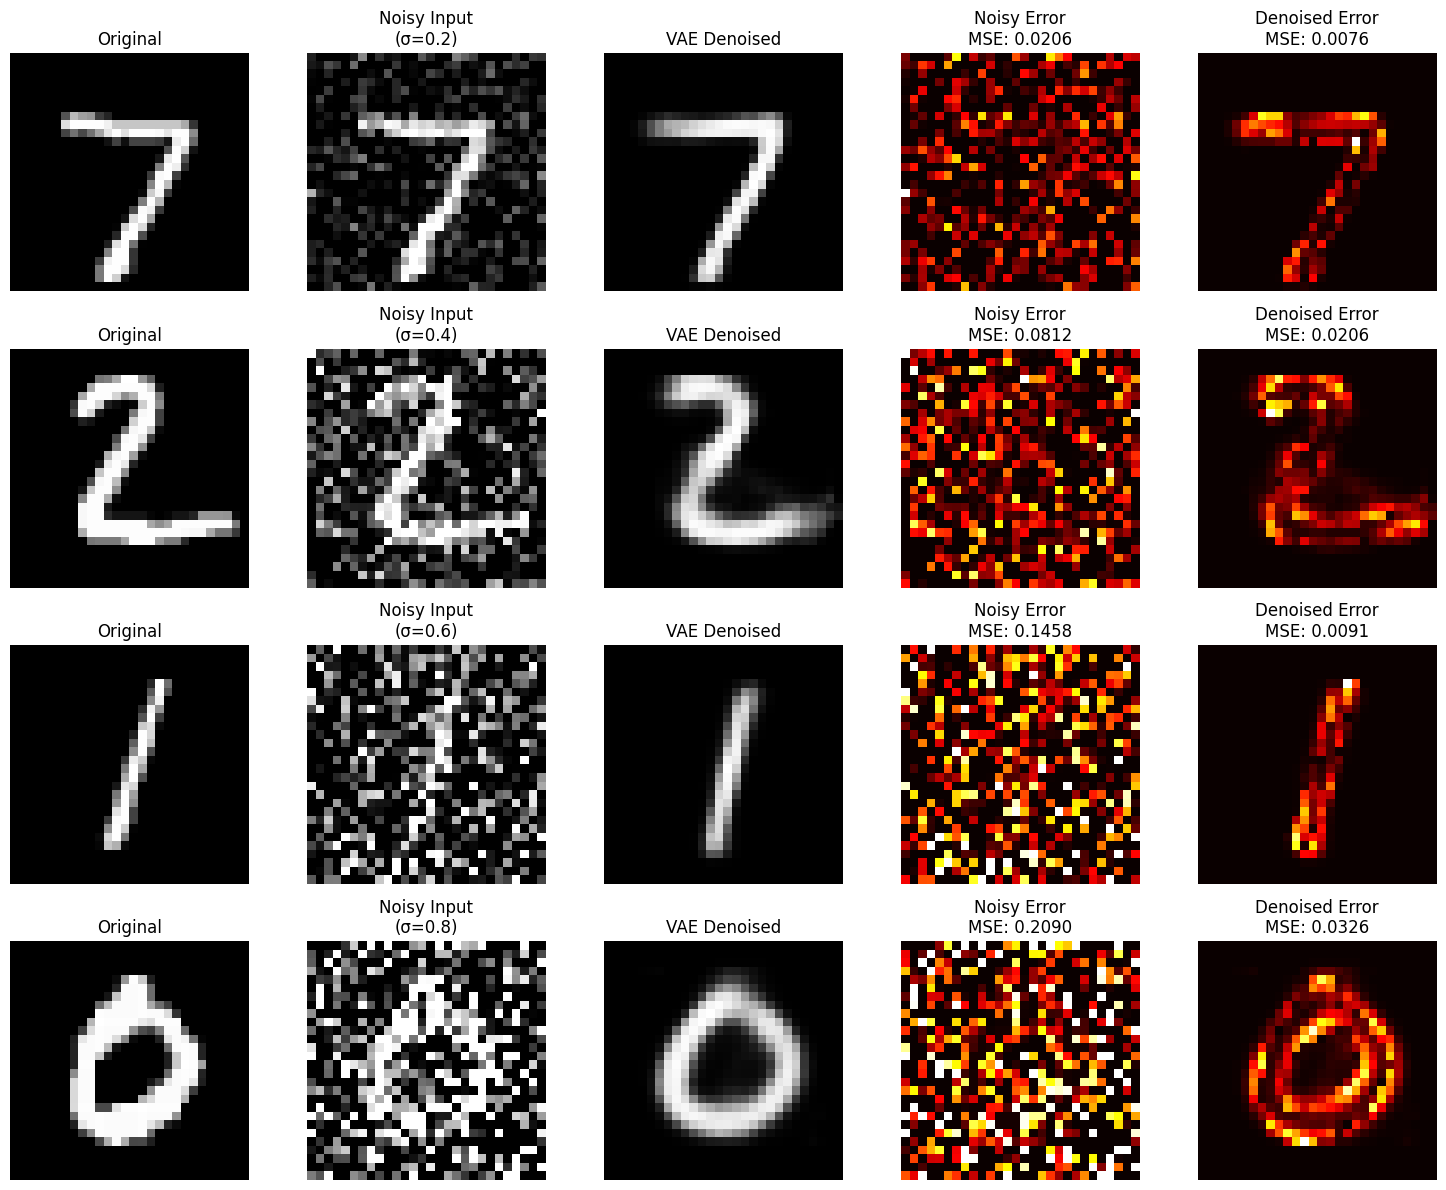

In [ ]:
# Test function
def test(model, dataloader):
    model.eval()
    test_loss = 0
    test_bce = 0
    test_kld = 0
    
    with torch.no_grad():
        for data, _ in dataloader:
            # Add noise to the data
            noisy_data = add_noise(data, noise_factor=0.5)
            noisy_data = noisy_data.to(device)
            data = data.to(device)
            
            recon_batch, mu, logvar = model(noisy_data)
            loss, bce, kld = vae_loss(recon_batch, data, mu, logvar)
            test_loss += loss.item()
            test_bce += bce.item()
            test_kld += kld.item()
    
    avg_loss = test_loss / len(dataloader.dataset)
    avg_bce = test_bce / len(dataloader.dataset)
    avg_kld = test_kld / len(dataloader.dataset)
    
    print(f'====> Test set loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}')
    return avg_loss, avg_bce, avg_kld

# Training loop
train_losses = []
test_losses = []

print("Starting training...")
for epoch in range(1, epochs + 1):
    train_loss, train_bce, train_kld = train(model, train_loader, optimizer, epoch)
    test_loss, test_bce, test_kld = test(model, test_loader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Visualization function
def visualize_results(model, dataloader, num_images=8):
    model.eval()
    with torch.no_grad():
        # Get a batch of test data
        data, _ = next(iter(dataloader))
        
        # Add different levels of noise
        noise_levels = [0.3, 0.5, 0.7]
        
        fig, axes = plt.subplots(len(noise_levels) + 1, num_images, figsize=(15, 10))
        
        # Show original images
        for i in range(num_images):
            axes[0, i].imshow(data[i].squeeze(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
        
        # Show noisy and denoised images for different noise levels
        for j, noise_factor in enumerate(noise_levels):
            noisy_data = add_noise(data, noise_factor=noise_factor)
            noisy_data = noisy_data.to(device)
            recon_data, _, _ = model(noisy_data)
            recon_data = recon_data.cpu()
            
            for i in range(num_images):
                # Noisy image
                axes[j+1, i].imshow(noisy_data[i].cpu().squeeze(), cmap='gray')
                axes[j+1, i].set_title(f'Noisy (σ={noise_factor})')
                axes[j+1, i].axis('off')
                
                # Calculate MSE for this image
                mse = F.mse_loss(recon_data[i].view(1, 28, 28), data[i]).item()
                axes[j+1, i].text(0.5, -0.15, f'MSE: {mse:.4f}', 
                                 transform=axes[j+1, i].transAxes, 
                                 ha='center', fontsize=8)
        
        plt.tight_layout()
        plt.show()

# Calculate quantitative metrics
def calculate_metrics(model, dataloader, noise_factor=0.5):
    model.eval()
    total_mse = 0
    total_psnr = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, _ in dataloader:
            noisy_data = add_noise(data, noise_factor=noise_factor)
            noisy_data = noisy_data.to(device)
            data = data.to(device)
            
            recon_data, _, _ = model(noisy_data)
            
            # Calculate MSE
            mse = F.mse_loss(recon_data, data.view(-1, 784), reduction='none')
            mse = mse.mean(dim=1).sum().item()
            total_mse += mse
            
            # Calculate PSNR
            mse_batch = F.mse_loss(recon_data, data.view(-1, 784), reduction='none')
            mse_batch = mse_batch.mean(dim=1)
            psnr_batch = 20 * torch.log10(1.0 / torch.sqrt(mse_batch))
            total_psnr += psnr_batch.sum().item()
            
            total_samples += data.size(0)
    
    avg_mse = total_mse / total_samples
    avg_psnr = total_psnr / total_samples
    
    print(f"Quantitative Results (noise σ={noise_factor}):")
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    
    return avg_mse, avg_psnr

# Display results
print("\nVisualizing results...")
visualize_results(model, test_loader)

print("\nCalculating quantitative metrics...")
calculate_metrics(model, test_loader, noise_factor=0.5)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

# Function to show individual examples with different noise levels
def show_detailed_examples(model, dataloader):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(dataloader))
        
        noise_factors = [0.2, 0.4, 0.6, 0.8]
        
        fig, axes = plt.subplots(4, 5, figsize=(15, 12))
        
        for i, noise_factor in enumerate(noise_factors):
            # Original
            axes[i, 0].imshow(data[i].squeeze(), cmap='gray')
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')
            
            # Noisy
            noisy_data = add_noise(data, noise_factor=noise_factor)
            axes[i, 1].imshow(noisy_data[i].squeeze(), cmap='gray')
            axes[i, 1].set_title(f'Noisy Input\n(σ={noise_factor})')
            axes[i, 1].axis('off')
            
            # Denoised
            noisy_data_device = noisy_data.to(device)
            recon_data, _, _ = model(noisy_data_device)
            recon_img = recon_data[i].cpu().view(28, 28)
            axes[i, 2].imshow(recon_img, cmap='gray')
            axes[i, 2].set_title('VAE Denoised')
            axes[i, 2].axis('off')
            
            # Calculate metrics
            mse_noisy = F.mse_loss(noisy_data[i], data[i]).item()
            mse_denoised = F.mse_loss(recon_img, data[i].squeeze()).item()
            
            # Error maps
            error_noisy = torch.abs(noisy_data[i] - data[i])
            error_denoised = torch.abs(recon_img - data[i].squeeze())
            
            axes[i, 3].imshow(error_noisy.squeeze(), cmap='hot')
            axes[i, 3].set_title(f'Noisy Error\nMSE: {mse_noisy:.4f}')
            axes[i, 3].axis('off')
            
            axes[i, 4].imshow(error_denoised, cmap='hot')
            axes[i, 4].set_title(f'Denoised Error\nMSE: {mse_denoised:.4f}')
            axes[i, 4].axis('off')
        
        plt.tight_layout()
        plt.show()

print("\nShowing detailed examples with error analysis...")
show_detailed_examples(model, test_loader)